# Elastic field around a Griffith crack

Plane Elastic problem

Displacements and stresses around a straight crack  $ x_1 \in [-a,a] $ under pure tensile loading $\sigma$.

We test the computation of the displacement and stress at observation points by setting the solution of the collocation BEM to the analytical solution on the BE mesh.


The crack displacement discontinuity is given by for $ x_1 \in [-a,a] $:

$\Delta u_1 (x_1,x_2=0)= u_1 (x_1,x_2=0^+)-u_1 (x_1,x_2=0^-)=0 $ 

$\Delta u_2 (x_1,x_2=0)= u_2 (x_1,x_2=0^+)-u_2 (x_1,x_2=0^-)= \frac{4 \sigma}{E^\prime} \sqrt{a^2-x_1^2} =\frac{2 (1-\nu) \sigma}{G} \sqrt{a^2-x_1^2}  $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.

In [1]:
import sys
import os

# load the analytical solution 

import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import displacement_griffith,stress_griffith


In [2]:
# %% importing BigWham 
import sys
import os
import numpy as np
import time


from bigwham4py import BEMatrix


In [3]:
#%% Elastic properties
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
Eprime = E/(1-nu**2)
# %% Mesh 
a = 1.
nelts = 101
coor1D = np.linspace(-a, a, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)


In [4]:
kernel = "2DP0-H"
elas_prop = np.array([E, nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-3
h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

colpts=h.getCollocationPoints()



 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  7e-06
 binary cluster tree depth =1
 Number of blocks =4
 Number of full blocks =4
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.005471
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 0.001, eta = 3
Hierarchical matrix  construction time = :  0.005493
--------------------


In [5]:
h.get_omp_threads()

NUM OF OMP THREADS: 16


16

In [6]:
# x
x_obs=np.linspace(-3*a,3*a,500)
yoffset = 0.17
obs_pts = np.transpose([x_obs , x_obs*0.+yoffset])
#
u,v = displacement_griffith(x_obs+yoffset*(1j),a=a,sig=1,nu=nu,G=G)


In [7]:
w = (4*1/Eprime)*np.sqrt(a**2-colpts[:,0]**2)   # Crack opening displacement discontinuity from analytical solution 
# compute displacement via BEM representation
d = np.transpose([w*0.,w])
zt = time.process_time()
disp=h.compute_displacements(obs_pts,-d)   # minus sign due to convention of positive dd in overlap in the inner of Bigwham....
zt = time.process_time()
elapsed = (time.process_time() - zt) 
#print("number of active threads for MatVec", h.get_omp_threads())
print("elapsed time", elapsed)


elapsed time 5.3999999999554404e-05


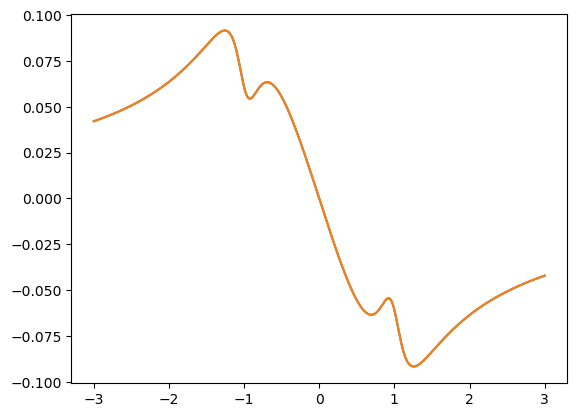

In [8]:
import matplotlib.pyplot as plt

# evolution of u_1 along a line at y = yoffset 
plt.plot(x_obs,disp[:,0])
plt.plot(x_obs,u)


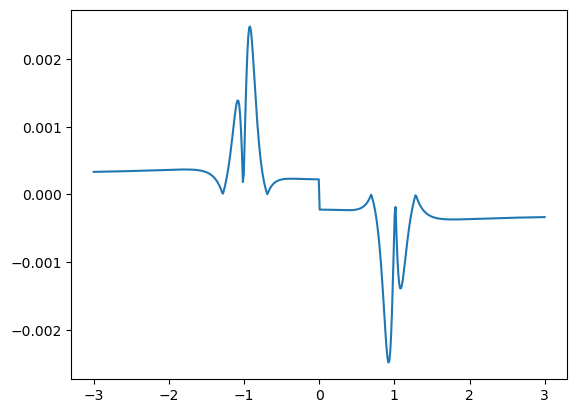

In [9]:
# relative difference
plt.plot(x_obs,abs(disp[:,0]-u)/u)


0.75

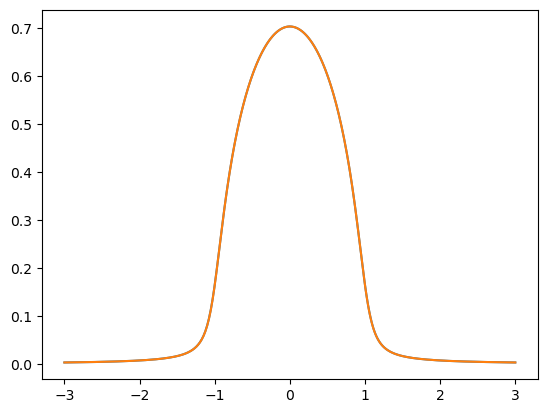

In [10]:
plt.plot(x_obs,disp[:,1])
plt.plot(x_obs,v)
2/Eprime
w.max()/2

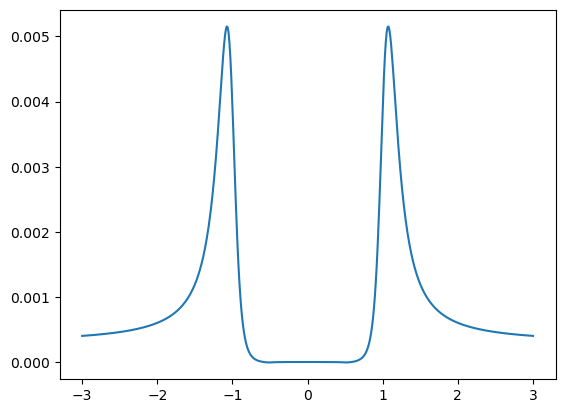

In [11]:
# relative difference
plt.plot(x_obs,abs(disp[:,1]-v)/v)

# Evolution of Stresses around a griffith crack

In [12]:
# results from collocation BEM observation (with known solution for the relative DD)
sigma=h.compute_stresses(obs_pts,-d)   # minus sign due to convention of positive dd in overlap in the inner of Bigwham....

In [13]:
# analytical results
s_11,s_22,s_12 = stress_griffith(x_obs+yoffset*(1j),a=a,sig=1,nu=nu)



9.347183722029084e-05

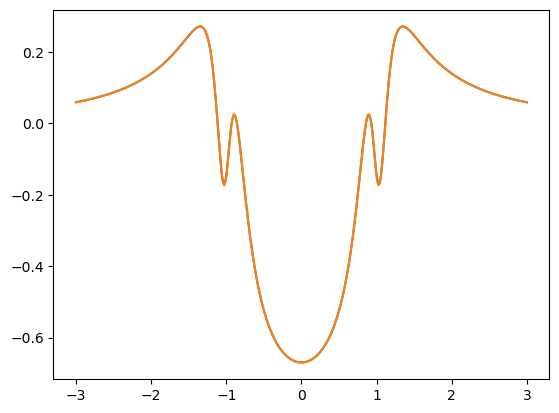

In [14]:
plt.plot(x_obs,sigma[:,0])
plt.plot(x_obs,s_11)
np.median(np.abs(s_11-sigma[:,0]))

0.00019351003345846607

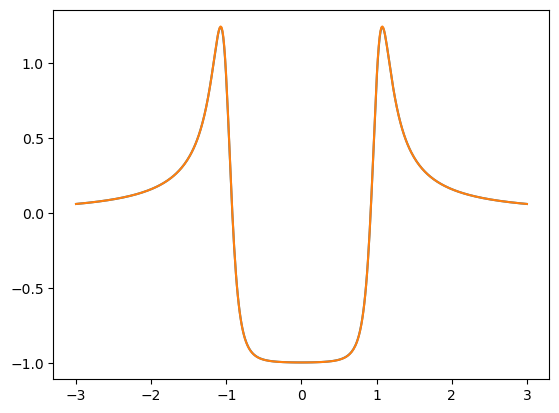

In [15]:
plt.plot(x_obs,sigma[:,1])
plt.plot(x_obs,s_22)
np.median(np.abs(s_22-sigma[:,1]))

4.110896181239339e-05

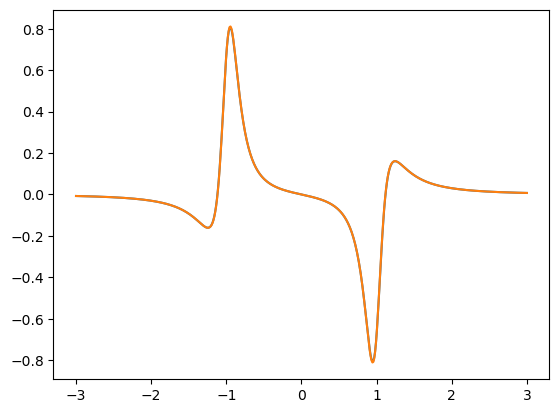

In [16]:
plt.plot(x_obs,sigma[:,2])
plt.plot(x_obs,s_12)
np.median(np.abs(s_12-sigma[:,2]))